In [1]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os
import common

In [2]:
# Reproducibility
common.set_seed(1)

In [3]:
class NN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(NN, self).__init__()
        self.A = torch.nn.Linear(ni, nh)
        self.relu = torch.nn.ReLU()
        self.B = torch.nn.Linear(nh, no)
    def forward(self, x):
        # Two layer neural network
        x = self.B(self.relu(self.A(x)))
        return x

In [4]:
# Train dataset
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True,
                       transform=torchvision.transforms.ToTensor())
# Train data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
# Point estimate NN
net = NN(28*28, 1024, 10)

In [5]:
def model(x, y):
    # Put priors on weights and biases 
    priors = {
        "A.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.weight), 
            scale=torch.ones_like(net.A.weight),
        ).independent(2),
        "A.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.bias), 
            scale=torch.ones_like(net.A.bias),
        ).independent(1),
        "B.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.weight), 
            scale=torch.ones_like(net.B.weight),
        ).independent(2),
        "B.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.bias), 
            scale=torch.ones_like(net.B.bias),
        ).independent(1),
    }
    # Create a NN module using the priors
    lmodule = pyro.random_module("module", net, priors)
    regressor = lmodule()
    # Do a forward pass on the NN module, i.e. yhat=f(x) and condition on yhat=y
    lhat = torch.nn.LogSoftmax(dim=1)(regressor(x))
    pyro.sample("obs", pyro.distributions.Categorical(logits=lhat).independent(1), obs=y)

In [6]:
softplus = torch.nn.Softplus()
def guide(x, y):
    # Create parameters for variational distribution priors
    Aw_mu = pyro.param("Aw_mu", torch.randn_like(net.A.weight))
    Aw_sigma = softplus(pyro.param("Aw_sigma", torch.randn_like(net.A.weight)))
    Ab_mu = pyro.param("Ab_mu", torch.randn_like(net.A.bias))
    Ab_sigma = softplus(pyro.param("Ab_sigma", torch.randn_like(net.A.bias)))
    Bw_mu = pyro.param("Bw_mu", torch.randn_like(net.B.weight))
    Bw_sigma = softplus(pyro.param("Bw_sigma", torch.randn_like(net.B.weight)))
    Bb_mu = pyro.param("Bb_mu", torch.randn_like(net.B.bias))
    Bb_sigma = softplus(pyro.param("Bb_sigma", torch.randn_like(net.B.bias)))
    # Create random variables similarly to model
    priors = {
        "A.weight": pyro.distributions.Normal(loc=Aw_mu, scale=Aw_sigma).independent(2),
        "A.bias": pyro.distributions.Normal(loc=Ab_mu, scale=Ab_sigma).independent(1),
        "B.weight": pyro.distributions.Normal(loc=Bw_mu, scale=Bw_sigma).independent(2),
        "B.bias": pyro.distributions.Normal(loc=Bb_mu, scale=Bb_sigma).independent(1),
    }
    # Return NN module from these random variables
    lmodule = pyro.random_module("module", net, priors)
    return lmodule()

In [7]:
# Do stochastic variational inference to find q(w) closest to p(w|D)
svi = pyro.infer.SVI(
    model, guide, pyro.optim.Adam({'lr': 0.01}), pyro.infer.Trace_ELBO(),
)

In [8]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with SVI
    for epoch in range(epochs):
        loss = 0.
        for data in train_loader:
            images, labels = data
            images = images.view(-1, 28*28)
            loss += svi.step(images, labels)
        loss /= len(train_loader.dataset)
        print("Epoch %g: Loss = %g" % (epoch, loss))
    # Sample k models from the posterior
    sampled_models = [guide(None, None) for i in range(K)]
    # Save the models
    nn_dicts = []
    for i in range(len(sampled_models)):
        nn_dicts += [sampled_models[i].state_dict()]
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [759]:
def load_models(K = 100):
    # Load the models
    sampled_models = [NN(28*28, 1024, 10) for i in range(K)]
    for net, state_dict in zip(sampled_models, torch.load("model.pt")):
        net.load_state_dict(state_dict)
    print("Loaded %d sample models" % K)
    return sampled_models

In [760]:
train_and_save_models(epochs = 10, K = 100, modelname = "model.pt")
sampled_models = load_models(K = 100)

File exists
Loaded 100 sample models


In [963]:
# Test dataset
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True,
                       transform=torchvision.transforms.ToTensor())
# Test data loader with batch_size 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [964]:
# Get a batch and flatten the input
images, targets = next(iter(test_loader))
images = images.reshape(-1, 28*28)

In [965]:
targets

tensor([8])

In [966]:
def forward_pass(model, images, loss_target = None):
    output = model(images)
    output = torch.nn.LogSoftmax(dim=-1)(output)
    which_class = torch.argmax(output).item()
    if loss_target:
        loss, target = loss_target
        loss(output, target).backward()
    return which_class

Adversarial example methods

In [967]:
def otcm(images, eps, saliency):
    return torch.clamp(images.clone() - (eps*saliency), 0, 1)

In [968]:
def fgsm(images, eps, saliency):
    return torch.clamp(images.clone() + (eps*saliency), 0, 1)

In [969]:
def bim(image, eps, model, steps, alpha, targets):
    with torch.no_grad():
        image_adv = torch.clone(image)
    for n in range(steps):
        image_adv.requires_grad = True
        image_adv.grad = None
        output = model(image_adv)             #forward pass
        output = torch.nn.LogSoftmax(dim=-1)(output)
        loss_fct = torch.nn.NLLLoss()
        loss = loss_fct(output, targets)       #compute loss
        loss.backward()
        with torch.no_grad():
            x_grad =  alpha * torch.sign(image_adv.grad)    
            adv_temp = image_adv.data + x_grad  #add perturbation to img_variable which 
            #also contains perturbation from previous iterations
            total_grad = torch.clamp(adv_temp - image, -eps, eps)
            image_adv.data = image + total_grad

    
    return image_adv

In [970]:
def itcm(image, eps, model, steps, alpha, targets):
    with torch.no_grad():
        image_adv = torch.clone(image)
    for n in range(steps):
        image_adv.requires_grad = True
        image_adv.grad = None
        output = model(image_adv)             #forward pass
        output = torch.nn.LogSoftmax(dim=-1)(output)
        loss_fct = torch.nn.NLLLoss()
        loss = loss_fct(output, targets)       #compute loss
        loss.backward()
        with torch.no_grad():
            x_grad =  alpha * torch.sign(image_adv.grad)    
            adv_temp = image_adv.data + x_grad  #add perturbation to img_variable which 
            #also contains perturbation from previous iterations
            total_grad = torch.clamp(adv_temp - image, -eps, eps)
            image_adv.data = image - total_grad
    
    return image_adv

In [985]:
# How many models can an adversarial example fool?
def how_many_can_it_fool(sampled_models, new_images):
    fool = 0
    for k in range(len(sampled_models)):
        # Forward pass on sampled model k
        old_class = forward_pass(sampled_models[k], images)
    
        # Forward pass again on adv. example
        new_class = forward_pass(sampled_models[k], new_images)

        # If we change the class, we fool the model
        fool += int(old_class != new_class)

    return fool/len(sampled_models)

In [986]:
# How many models can an adversarial example fool (for iterative methods)?
def how_many_can_it_fool2(sampled_models, eps, saliency):
    fool = 0
    for k in range(len(sampled_models)):
        # Forward pass on sampled model k
        old_class = forward_pass(sampled_models[k], images)
        
        # One step Target Class Method (OTCM); saliency is noise
        #new_images = otcm(images, eps, saliency)
        
        # Fast Gradient Sign Method (FGSM)
        new_images = fgsm(images, eps, saliency)
        
        #Basic Iterative Method (BIM-untargeted)
        #new_images = bim(images, eps, sampled_models[k], 15, eps*0.25, targets)
        
        #Iterative Target Class Method (ITCM)
        #new_images = itcm(images, eps, sampled_models[k], 15, eps*0.25, torch.tensor([9]))
        
        # Forward pass again on adv. example
        new_class = forward_pass(sampled_models[k], new_images)
        
        # If we change the class, we fool the model
        fool += int(old_class != new_class)
    return fool/len(sampled_models)

Experiment: 



Create 100 adv examples from the 100 sampled models.

Test how many of the 100 sampled models each of the adv. examples can fool. 

Then combine to get one strong adv example, and test how many THIS example can fool

In [987]:
# Collect noises (saliencies)
EPS = 0.18
saliencies = []
how_many_fooled = []
torch.set_printoptions(sci_mode=False)
for k in tqdm.tqdm(range(len(sampled_models))):
    images.grad = None
    images.requires_grad = True
    
    #### Get old class/target ####
    #Using OTCM or ITCM:
    #old_class = forward_pass(sampled_models[k], images, [torch.nn.NLLLoss(), torch.tensor([9])])
    
    #Using FGSM or BIM:
    old_class = forward_pass(sampled_models[k], images, [torch.nn.NLLLoss(), targets])
    
    
    #### Compute adversarial examples ####
    #Using OTCM:
    #new_images = otcm(images, EPS, images.grad.sign())
    
    #Using FGSM:
    new_images = fgsm(images, EPS, images.grad.sign())
    
    #Using BIM:
    #new_images = bim(images, EPS, sampled_models[k], 15, EPS*0.25, targets)
    
    #Using ITCM:
    #new_images = itcm(images, EPS, sampled_models[k], 15, EPS*0.25, torch.tensor([9]))
    
    #### Forward pass on adv. example to get new class####
    new_class = forward_pass(sampled_models[k], new_images)

    if old_class != new_class:
        # How many models can this adv. example fool?
        how_many_fooled += [how_many_can_it_fool(sampled_models, new_images)]

        #saliencies += [(new_images-images).sign().detach().view(28, 28)]
        saliencies += [images.grad.sign().view(28, 28)]
print(how_many_fooled)

100%|██████████| 100/100 [00:02<00:00, 37.53it/s]

[0.08, 0.12, 0.18, 0.14, 0.1, 0.19, 0.15, 0.11, 0.13, 0.09, 0.19, 0.07, 0.11, 0.13, 0.12, 0.09, 0.11, 0.14, 0.18, 0.17, 0.09, 0.17, 0.13, 0.09, 0.18, 0.14, 0.07, 0.14, 0.12, 0.12, 0.18, 0.12, 0.15]


In [988]:
#### Combining disturbance ####
# distributional saliency map
saliencies = torch.stack(saliencies)
print(saliencies.shape)
newsaliency = torch.zeros(28, 28)
for i in range(28):
    for j in range(28):
        # choose median perturbation
        newsaliency[i, j] = np.percentile(saliencies[:, i, j].numpy(), 50)
newsaliency = newsaliency.flatten()


torch.Size([33, 28, 28])


In [991]:
#### Get strong adv_example using new/combined saliency ####
new_images = fgsm(images, EPS, newsaliency)



#### Test how many of the 100 models this strong adv example can fool ####

#For FGSM or OTCM
#foolrate_comb = how_many_can_it_fool(sampled_models, new_images)

#For BIM or ITCM
foolrate_comb = how_many_can_it_fool2(sampled_models, EPS, newsaliency)

print('Combined example fooling rate:', foolrate_comb)


Combined example fooling rate: 0.35


In [992]:
#Compare the average fooling rate of the individual examples to the combined fooling rate

avg_foolrate_ind = np.mean(how_many_fooled)
print('Average of individual example fooling rates', avg_foolrate_ind)

print('Increase:',foolrate_comb-avg_foolrate_ind)

Average of individual example fooling rates 0.13030303030303034
Increase: 0.21969696969696964


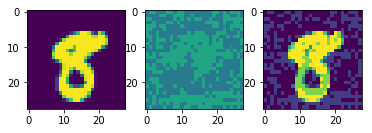

In [984]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(images.reshape(28, 28).detach().numpy())
plt.subplot(1, 3, 2)
plt.imshow((newsaliency*EPS).reshape(28, 28).detach().numpy(), vmin=-1., vmax=1.)
plt.subplot(1, 3, 3)
plt.imshow(new_images.reshape(28, 28).detach().numpy())
plt.show()